# **Combinación de clasificadores: Ensemble Learning**

La técnicas de aprendizaje ensamble consisten en combinar diferentes modelos de ML para obtener mejores predicciones que las que nos proporcionarían dichos modelos por separado. Existen multitud de técnicas de ensamblado, aunque en este notebook veremos unos pocos solamente.

## Clasificadores por votación

Para inicar hablaremos de los esquemas ensemble que utilizan el enfoque de votación.

Esta es una de las técnicas más sencillas, y como su propio nombre indica simplemente agregaremos las predicciones de diferentes clasificadores quedándonos con la clase más votada.
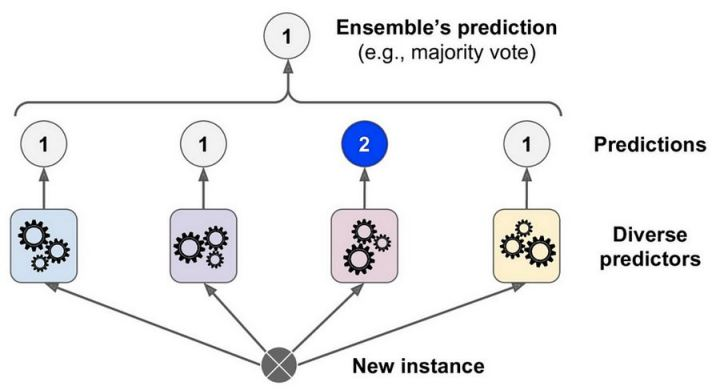

En *Scikit-Learn* puedes usar el objeto [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html), que usamos en el siguiente ejemplo en el que ensamblamos un modelo de regresión logística, un SVM y un árbol de decisión.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)
tree_cf = DecisionTreeClassifier(max_depth=2, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svm_clf), ('rf', tree_cf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('rf',
                              DecisionTreeClassifier(max_depth=2,
                                                     random_state=42))])

Cada modelo por separado es capaz de dar su predicción, el modelo ensamblado asignará, para cada instancia de test, aquella clase con mayor número de votos. El modelo resultante (mayor diversidad en los errores) debe tener mejor prestaciones que los modelos individuales.

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, tree_cf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.896
SVC 0.896
VotingClassifier 0.904


Este método de clasificación por votación se conoce como *hard voting*, escoger la clase más votada. Sin embargo, promediar las probabilidades que obtenemos de los diferentes modelos y escoger aquella clase con mayor probabilidad suele dar mejores resultados.

Este proceso se conoce como *soft voting*.


In [ ]:
voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', tree_cf)],
    voting='soft')

voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf',
                              DecisionTreeClassifier(max_depth=2,
                                                     random_state=42))],
                 voting='soft')

In [ ]:
for clf in (log_clf, tree_cf, svm_clf, voting_clf_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.896
SVC 0.896
VotingClassifier 0.896


## **Bagging**

Otra alternativa en el aprendizaje ensemble consiste en usar el mismo modelo, pero entrenado con diferentes subconjunto de datos de entrenamiento. Si cada modelo es entrenado con un subconjunto único, la técnica se llama **pasting**. En caso contrario, se llama *bagging* (abreviación de *bootstrap aggregating*), lo cual es más común y la técnica usada en los *Random Forest*.


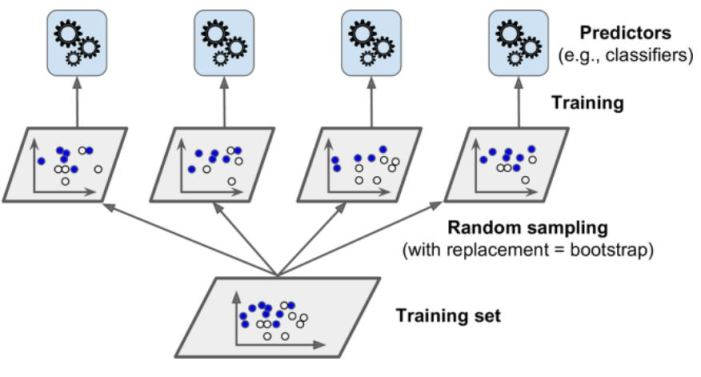

Una vez los modelos han sido entrenados, se pueden sacar predicciones agregando las predicciones de todos los modelos mediante un mecanismo de votación como el que hemos visto en la sección anterior (o promediando los valores en una tarea de regresión).


Como ya vimos en clase, *Random Forest* no es más que un método ensemble basado en árboles de decisión los cuales son entrenados usando la técnica de *bagging*. En *Scikit-Learn*, puedes usar el modelo [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier) directamente.

Una de las cualidades más interesantes de los *Random Forest* es la capacidad de considerar la importancia relativa de cada característica, midiendo la cantidad en la que los nodos y la impureza. Ésto hace que los *Random Forest* sean muy útiles para  aplicaciones en las que la explicabilidad del modelo sea de importancia vital.



---



In [ ]:
%matplotlib inline

import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

np.random.seed(0)

In [ ]:
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target


clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf2 = KNeighborsClassifier(n_neighbors=1)

bagging1 = BaggingClassifier(estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)

Accuracy: 0.63 (+/- 0.02) [Decision Tree]
Accuracy: 0.71 (+/- 0.03) [K-NN]
Accuracy: 0.73 (+/- 0.06) [Bagging Tree]
Accuracy: 0.65 (+/- 0.01) [Bagging K-NN]


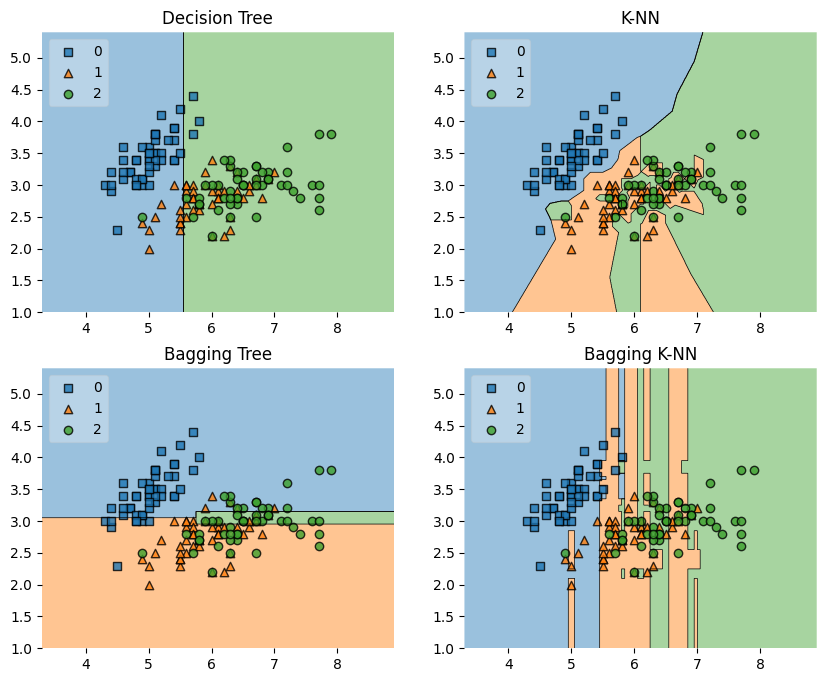

In [ ]:
label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf1, clf2, bagging1, bagging2]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

La figura siguiente muestra las curvas de aprendizaje del conjunto del enfoque bagging con árboles de decisión.

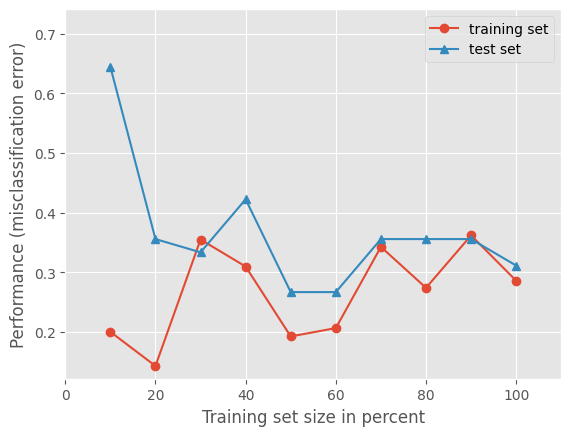

In [ ]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, bagging1, print_model=False, style='ggplot')
plt.show()

In [ ]:
#Ensemble Size
num_est = list(map(int, np.linspace(1,100,20))) # Convert num_est to a list
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    bg_clf = BaggingClassifier(estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8, random_state=42)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

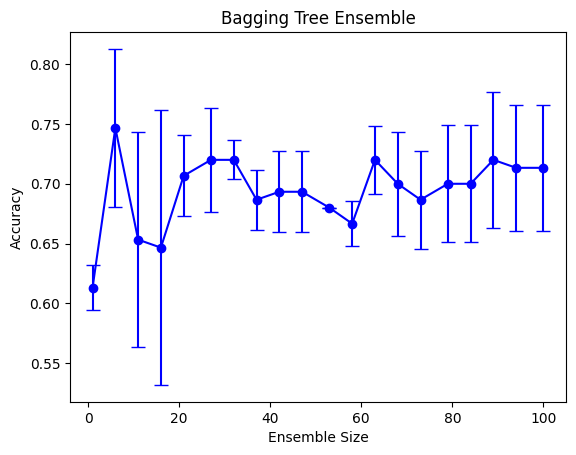

In [ ]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()



---



## *Boosting*

La técnica de *Boosting* consiste en entrenar modelos de manera secuencial, cada uno intentando corregir los errores del modelos predecesor. Las técnicas de *boosting* más populares son *AdaBoost* y *Gradient Boosting*.

### *AdaBoost*

En la técnica de *AdaBoost* cada modelo intenta corregir a su predecesor prestando más atención a las muestras de entrenamiento a las cuales el modelo anterior hizo *underfitting*.

1.   Se inicia entrenando un clasificador básico, el cual es utilizado para hacer predicciones en los datos de entrenamiento.

2.   El algoritmo aumenta la importancia relativa de aquellas muestras que han sido clasificadas erróneamente.

3.   Se entrena un segundo clasificador utilizando estos nuevos pesos y así sucesivamente.

4.   Una vez todos los modelos han sido entrenados, se hace una predicción en ensamblado de votación con la diferencia de que cada predicción lleva asociada un peso que depende de su precisión promedia en el dataset modificado.


En *Scikit-Learn* podemos usar el objeto [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboostclassifier#sklearn.ensemble.AdaBoostClassifier).



---



In [ ]:
import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [ ]:
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
n_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

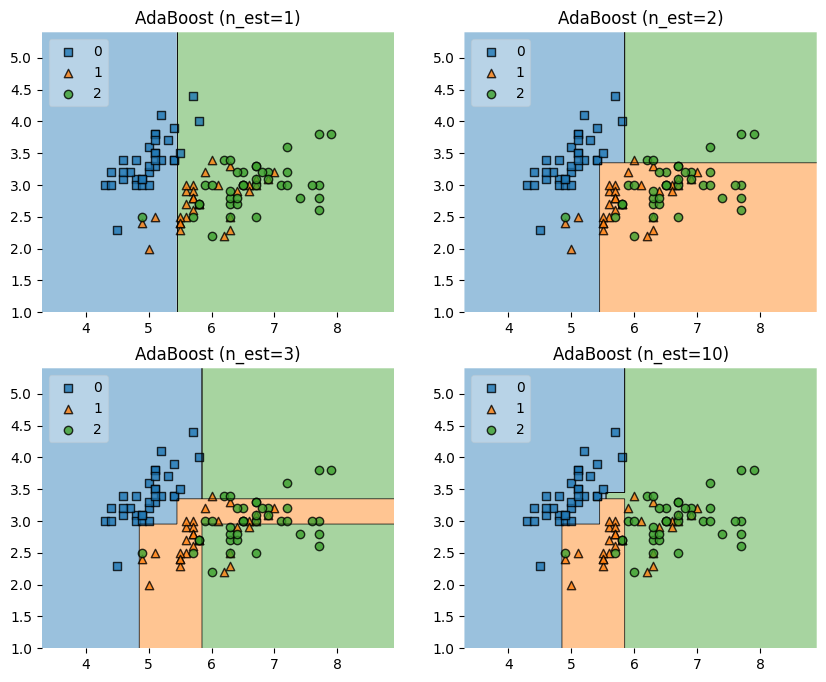

In [ ]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):
    boosting = AdaBoostClassifier(estimator=clf, n_estimators=n_est)
    boosting.fit(X_train, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train, y=y_train, clf=boosting, legend=2)
    plt.title(label)

plt.show()

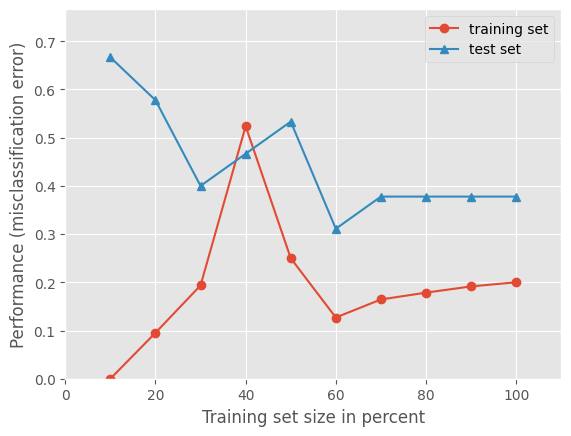

In [ ]:
#plot learning curves
boosting = AdaBoostClassifier(estimator=clf, n_estimators=10)

plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, boosting, print_model=False, style='ggplot')
plt.show()

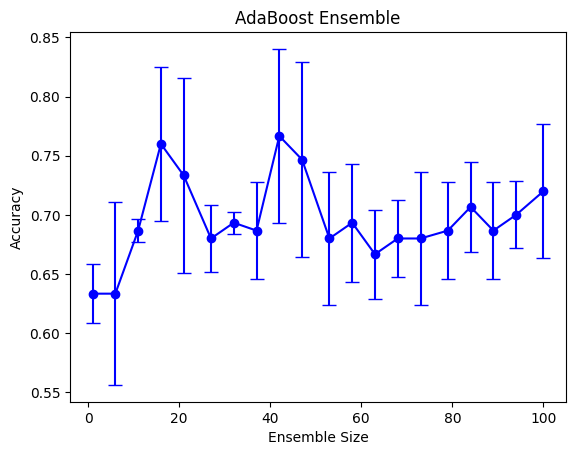

In [ ]:
#Ensemble Size
num_est = list(map(int, np.linspace(1,100,20))) # convert num_est to a list
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X, y, cv=3, scoring='accuracy')

    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())


plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()



---



## *Stacking*

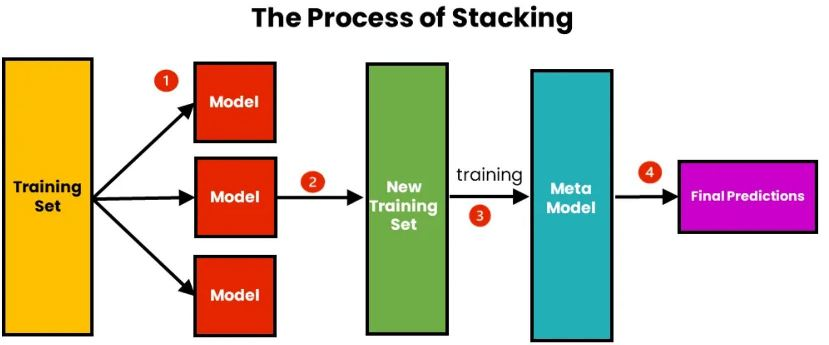

El stacking es una estrategia de aprendizaje automático que combina las predicciones de numerosos modelos base, también conocidos como modelos de primer nivel o baseline learners, para obtener una predicción final. Implica entrenar numerosos modelos base en el mismo conjunto de datos de entrenamiento y luego introducir sus predicciones en un modelo de nivel superior, también conocido como **metamodelo** o modelo de segundo nivel, para hacer la predicción final. La idea principal detrás del apilamiento es combinar las predicciones de diferentes modelos base para obtener un rendimiento predictivo más extraordinario que utilizar un solo modelo.

**La idea principal del stacking es introducir las predicciones de numerosos modelos base en un modelo de nivel superior conocido como metamodelo, que luego los combina para obtener el pronóstico final.**

## Etapas

1. Preparación de los datos.
2. Elección del modelo. El siguiente paso es elegir los modelos base que se utilizarán en el conjunto de stacking. Por lo general, se elige una amplia selección de modelos para garantizar produzcan diferentes tipos de errores y se complementen entre sí.
3. Entrenamiento de los modelos base.
4. Predicciones en el conjunto de datos de validación.
5. Desarrollo del Metamodelo: La siguiente etapa es desarrollar un metamodelo, que tomará las predicciones de los modelos subyacentes como entrada y realizará la predicción final. Para crear este modelo se puede utilizar cualquier algoritmo, como regresión lineal, regresión logística o incluso una red neuronal.
6. Entrenamiento del Metamodelo: El metamodelo se entrena utilizando las predicciones dadas por los modelos base en el conjunto de validación. Las predicciones de los modelos base sirven como características para el metamodelo.
7. Predicciones para el conjunto de validación: Finalmente, el metamodelo se utiliza para producir predicciones para el conjunto de validación. Las predicciones de los modelos básicos en el conjunto de validación se introducen en el metamodelo, que luego realiza la predicción final.
8. Evaluación del modelo in situs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, log_loss

In [ ]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**About Dataset**
Context

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

[REVISAR EL DATASET AQUÍ](https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download)

In [ ]:
df.info()
df['Churn'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,count
Churn,
No,5174
Yes,1869


In [ ]:
# Convert 'TotalCharges' column to numerical
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)

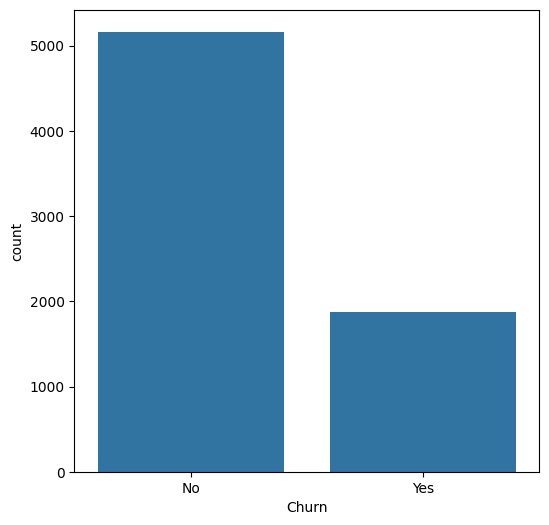

In [ ]:
# Plot 1: Class Distribution (Churn vs. Non-Churn)
plt.figure(figsize=(6, 6))
ax = sns.countplot(data=df, x='Churn')

In [ ]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaymentMethod']

target = 'Churn'

In [ ]:
# Codificamos las variables categóricas, y escalamos las numéricas

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
scaler = StandardScaler()

X_train, X_val, y_train, y_val = train_test_split(df.drop(target, axis=1), df[target], test_size=0.2, random_state=42)

X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_val_encoded = encoder.transform(X_val[categorical_features])

X_train_scaled = scaler.fit_transform(X_train[numerical_features])
X_val_scaled = scaler.transform(X_val[numerical_features])

X_train_processed = np.concatenate((X_train_encoded, X_train_scaled), axis=1)
X_val_processed = np.concatenate((X_val_encoded, X_val_scaled), axis=1)
y_val_processed = y_val

## Elección de algoritmos

- Base 1: Random Forest Classifier (rf)
- Base 2: Gradient Boosting Classifier (gb)
- Base 3: Support Vector Machine (svm)
- Meta-model: Logistic Regression (logreg)

In [ ]:
# Create models with suggested hyperparameters
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
svm = SVC(probability=True)

In [ ]:
# Train individual models
rf.fit(X_train_processed, y_train)
gb.fit(X_train_processed, y_train)
svm.fit(X_train_processed, y_train)

SVC(probability=True)

In [ ]:
# Evaluate individual models on validation data
rf_predictions = rf.predict(X_val_processed)
gb_predictions = gb.predict(X_val_processed)
svm_predictions = svm.predict(X_val_processed)

from sklearn.metrics import classification_report

target_names = ['Yes', 'No']
print(classification_report(y_val, rf_predictions, target_names=target_names))

              precision    recall  f1-score   support

         Yes       0.81      0.87      0.84      1033
          No       0.56      0.44      0.49       374

    accuracy                           0.76      1407
   macro avg       0.68      0.66      0.67      1407
weighted avg       0.74      0.76      0.75      1407





---



In [ ]:
print(classification_report(y_val, gb_predictions, target_names=target_names))


              precision    recall  f1-score   support

         Yes       0.83      0.90      0.86      1033
          No       0.62      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407





---



In [ ]:
print(classification_report(y_val, svm_predictions, target_names=target_names))


# Calculate accuracy and ROC AUC for individual models
rf_accuracy = accuracy_score(y_val, rf_predictions)
gb_accuracy = accuracy_score(y_val, gb_predictions)
svm_accuracy = accuracy_score(y_val, svm_predictions)


              precision    recall  f1-score   support

         Yes       0.82      0.91      0.86      1033
          No       0.64      0.45      0.53       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.77      1407





---



In [ ]:
rf_f1 = f1_score(y_val, rf_predictions, average='binary', pos_label='Yes')
gb_f1 = f1_score(y_val, gb_predictions, average='binary', pos_label='Yes')
svm_f1 = f1_score(y_val, svm_predictions, average='binary', pos_label='Yes')

In [ ]:
# Create a stacking ensemble with trained models
estimators = [
    ('random_forest', rf),
    ('gradient_boosting', gb),
    ('svm', svm)]

stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [ ]:
# Train the stacking ensemble
stacking_classifier.fit(X_train_processed, y_train)

StackingClassifier(estimators=[('random_forest', RandomForestClassifier()),
                               ('gradient_boosting',
                                GradientBoostingClassifier()),
                               ('svm', SVC(probability=True))],
                   final_estimator=LogisticRegression())

In [ ]:
# Evaluate the stacking ensemble on validation data
stacking_predictions = stacking_classifier.predict(X_val_processed)
stacking_accuracy = accuracy_score(y_val, stacking_predictions)
stacking_roc_auc = f1_score(y_val, stacking_predictions, average='binary', pos_label='Yes')
print(classification_report(y_val, stacking_predictions, target_names=target_names))

              precision    recall  f1-score   support

         Yes       0.82      0.91      0.86      1033
          No       0.64      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407



In [ ]:
print('Accuracy for RF:'+str(rf_accuracy))
print('Accuracy for GB:'+str(rf_accuracy))
print('Accuracy for SVM:'+str(rf_accuracy))
print('Accuracy for Stacking:'+str(stacking_accuracy))

Accuracy for RF:0.7583511016346838
Accuracy for GB:0.7583511016346838
Accuracy for SVM:0.7583511016346838
Accuracy for Stacking:0.7889125799573561




---



In [ ]:
print('F1 Score for RF:'+str(rf_f1))
print('F1 Score for GB:'+str(gb_f1))
print('F1 Score for SVM:'+str(svm_f1))
print('F1 Score for Stacking:'+str(stacking_roc_auc))

F1 Score for RF:0.49404761904761907
F1 Score for GB:0.5402124430955993
F1 Score for SVM:0.5289514866979655
F1 Score for Stacking:0.5409582689335394


Shape of X_train_processed: (5625, 18)
Shape of y_train: (5625,)
Shape of X_val_processed: (1407, 18)
Shape of y_test: (45,)
Shape of y_test_predict: (1407,)


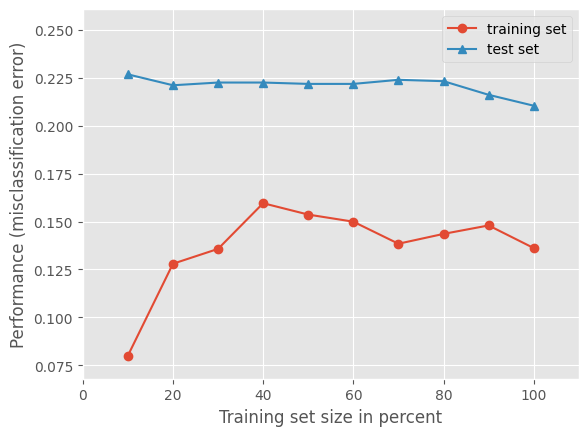

In [ ]:
#plot learning curves
plt.figure()
# Check the shapes of your data
print("Shape of X_train_processed:", X_train_processed.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val_processed:", X_val_processed.shape)
print("Shape of y_test:", y_test.shape)

# Ensure y_test and the predictions on X_val_processed have the same size
y_test_predict = stacking_classifier.predict(X_val_processed)
print("Shape of y_test_predict:", y_test_predict.shape)

# If shapes are still mismatched, adjust your data splitting or model training process
# For example, if y_test contains all targets, select the correct portion for validation
#y_test = y_test[:X_val_processed.shape[0]]  # Adjust the slicing as needed

# Now call plot_learning_curves with potentially corrected data
plot_learning_curves(X_train_processed, y_train, X_val_processed, y_val_processed, stacking_classifier, print_model=False, style='ggplot')
plt.show()